In [ ]:
import requests
import pandas as pd
from datetime import datetime

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", limit=240):
    # API Endpoint
    url = "https://fapi.binance.com/fapi/v1/klines" #v1: futures 
    #"https://api.binance.com/api/v3/klines"
    
    # Parameters
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": limit  # Max 1000
    }
    
    # Fetch Data
    response = requests.get(url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    
    # Cleaning
    # Convert timestamps to readable dates
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    
    # Convert string prices to floats
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    filename = f"{symbol.lower()}_{interval}.csv"
    df.to_csv(filename, index=False)
    return df[["open_time", "open", "high", "low", "close", "volume"]]

# Usage
df = get_binance_ohlcv(symbol="RIVERUSD", interval="1h")
df.tail()

,open_time,open,high,low,close,volume


In [19]:
import requests
import pandas as pd
from datetime import datetime

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", limit=240):
    # API Endpoint (Spot Market)
    url = "https://fapi.binance.com/fapi/v1/klines" #v1: futures 
    # url = "https://api.binance.com/api/v3/klines" #v3: spot
    
    # Parameters
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": limit
    }
    
    try:
        # Fetch Data
        response = requests.get(url, params=params)
        data = response.json()
        
        # CHECK 1: Handle API Errors (Binance returns a dict like {'code': -1121, 'msg': 'Invalid symbol.'} on failure)
        if isinstance(data, dict) and "code" in data:
            print(f"Error fetching {symbol}: {data.get('msg')} (Code: {data.get('code')})")
            return None

        # CHECK 2: Handle Empty Data (Valid symbol but no trading data for timeframe)
        if not data or len(data) == 0:
            print(f"No data found for symbol: {symbol}")
            return None
            
        # If we pass checks, create DataFrame
        df = pd.DataFrame(data, columns=[
            "open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "number_of_trades",
            "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
        ])
        
        # Cleaning
        df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
        df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
        
        numeric_cols = ["open", "high", "low", "close", "volume"]
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
        
        # Save to CSV
        filename = f"{symbol.lower()}_{interval}.csv"
        df.to_csv(filename, index=False)
        print(f"Successfully saved {filename}")
        
        return df[["open_time", "open", "high", "low", "close", "volume"]]

    except requests.exceptions.RequestException as e:
        print(f"Network error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Usage
df = get_binance_ohlcv(symbol="RIVERUSDT", interval="1h")

if df is not None:
    print(df.tail())
else:
    print("Skipping processing due to missing data.")

Successfully saved riverusdt_1h.csv
              open_time    open    high     low   close    volume
235 2026-01-24 13:00:00  50.177  51.880  48.545  51.340  714904.7
236 2026-01-24 14:00:00  51.340  56.285  50.900  53.902  977609.9
237 2026-01-24 15:00:00  53.899  55.276  53.026  54.068  706003.9
238 2026-01-24 16:00:00  54.069  57.200  53.520  55.374  730679.0
239 2026-01-24 17:00:00  55.375  56.666  55.211  56.314   83202.9


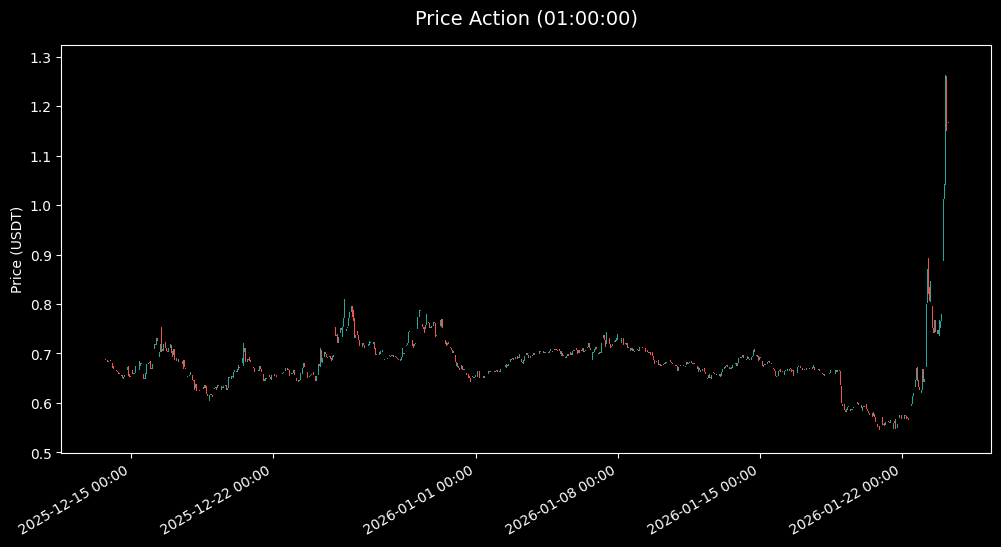

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_candlestick_mpl(df, timestamp_col, timestep=None):
    """
    Plots a professional candlestick chart using pure Matplotlib.
    
    Args:
        df (pd.DataFrame): Data with 'open', 'high', 'low', 'close'.
        timestamp_col (str): Column name for time.
        timestep (int, optional): Number of rows to combine into one candle.
    """
    # 1. Prepare Data
    plot_df = df.copy()
    
    # Ensure datetime format
    if not pd.api.types.is_datetime64_any_dtype(plot_df[timestamp_col]):
        first_ts = plot_df[timestamp_col].iloc[0]
        unit = 'ms' if len(str(int(first_ts))) >= 13 else 's'
        plot_df[timestamp_col] = pd.to_datetime(plot_df[timestamp_col], unit=unit)

    plot_df = plot_df.set_index(timestamp_col).sort_index()

    # 2. Resample Logic (Same as before)
    base_diff = plot_df.index.to_series().diff().mode()[0]
    
    if timestep is not None and isinstance(timestep, int) and timestep > 1:
        new_frequency = base_diff * timestep
        agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}
        plot_df = plot_df.resample(new_frequency).agg(agg_dict).dropna()
        freq_str = str(new_frequency).replace('0 days ', '')
        title_text = f"Price Action ({timestep}x Resample: {freq_str})"
    else:
        freq_str = str(base_diff).replace('0 days ', '')
        title_text = f"Price Action ({freq_str})"

    # 3. Setup Plotting Data
    # Reset index to get access to dates for plotting
    plot_df = plot_df.reset_index()
    # Convert dates to matplotlib number format for easy math on widths
    plot_df['mdate'] = mdates.date2num(plot_df[timestamp_col])
    
    # Define colors
    col_up = '#26a69a'   # Green (Binance style)
    col_down = '#ef5350' # Red (Binance style)
    
    # Split into Up and Down dataframes
    up = plot_df[plot_df['close'] >= plot_df['open']]
    down = plot_df[plot_df['close'] < plot_df['open']]

    # 4. Create Plot
    plt.style.use('dark_background') # Dark theme
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate bar width (80% of the time interval between candles)
    if len(plot_df) > 1:
        dist = plot_df['mdate'].iloc[1] - plot_df['mdate'].iloc[0]
        width = dist * 0.8
        width2 = dist * 0.1 # Width for wicks
    else:
        width = 0.02 # Fallback

    # Plot Up Candles
    ax.bar(up['mdate'], up['close'] - up['open'], bottom=up['open'], width=width, color=col_up, align='center')
    ax.bar(up['mdate'], up['high'] - up['close'], bottom=up['close'], width=width2, color=col_up, align='center') # Top Wick
    ax.bar(up['mdate'], up['low'] - up['open'], bottom=up['open'], width=width2, color=col_up, align='center')    # Bottom Wick

    # Plot Down Candles
    ax.bar(down['mdate'], down['close'] - down['open'], bottom=down['open'], width=width, color=col_down, align='center')
    ax.bar(down['mdate'], down['high'] - down['open'], bottom=down['open'], width=width2, color=col_down, align='center') # Top Wick
    ax.bar(down['mdate'], down['low'] - down['close'], bottom=down['close'], width=width2, color=col_down, align='center')  # Bottom Wick

    # 5. Formatting
    ax.set_title(title_text, fontsize=14, color='white', pad=15)
    ax.set_ylabel("Price (USDT)")
    # ax.grid(True, color='#2a2e39') # Subtle grid
    
    # Format Date Axis
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate() # Rotate dates slightly

    plt.show()

# --- Example Usage ---
# df = get_binance_ohlcv("BTCUSDT", "1h")
plot_candlestick_mpl(df, "open_time", timestep=1)

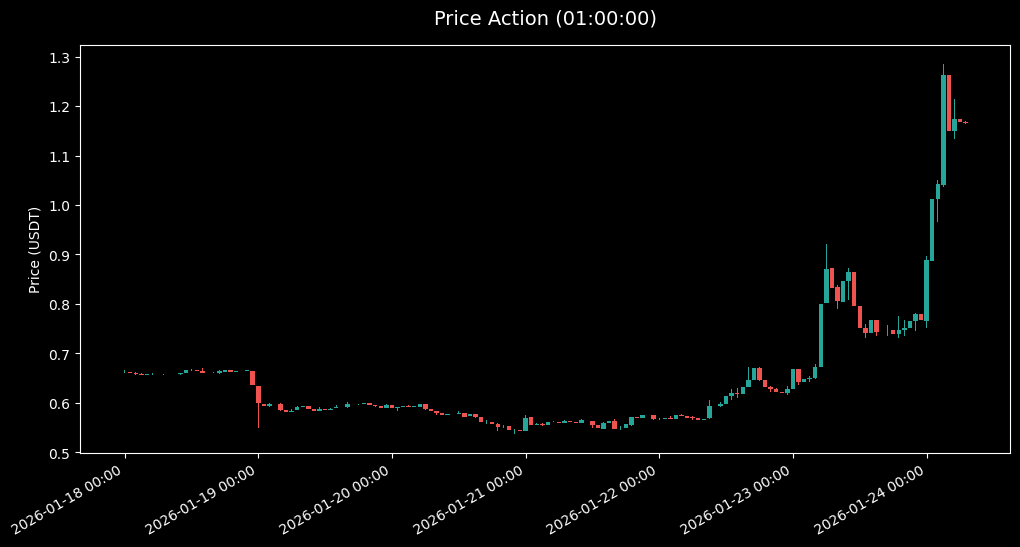

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_candlestick_mpl(df, timestamp_col, timestep=None, start_date=None):
    """
    Plots a candlestick chart with optional start date filtering.
    
    Args:
        df (pd.DataFrame): Data with 'open', 'high', 'low', 'close'.
        timestamp_col (str): Column name for time.
        timestep (int, optional): Number of rows to combine into one candle.
        start_date (str, optional): Filter data from this date (format 'yyyy-mm-dd').
    """
    # 1. Prepare Data
    plot_df = df.copy()
    
    # Ensure datetime format for the column
    if not pd.api.types.is_datetime64_any_dtype(plot_df[timestamp_col]):
        first_ts = plot_df[timestamp_col].iloc[0]
        # Auto-detect ms vs seconds
        unit = 'ms' if len(str(int(first_ts))) >= 13 else 's'
        plot_df[timestamp_col] = pd.to_datetime(plot_df[timestamp_col], unit=unit)

    # 2. Filter by Start Date (New Logic)
    if start_date:
        # Convert string to datetime and filter
        filter_date = pd.to_datetime(start_date)
        plot_df = plot_df[plot_df[timestamp_col] >= filter_date]
        
        if plot_df.empty:
            print(f"Error: No data found on or after {start_date}")
            return

    # Set index for resampling
    plot_df = plot_df.set_index(timestamp_col).sort_index()

    # 3. Resample Logic
    # Calculate base frequency from the filtered data
    if len(plot_df) > 1:
        base_diff = plot_df.index.to_series().diff().mode()[0]
    else:
        # Fallback if only 1 row exists
        base_diff = pd.Timedelta('1min')

    if timestep is not None and isinstance(timestep, int) and timestep > 1:
        new_frequency = base_diff * timestep
        agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}
        plot_df = plot_df.resample(new_frequency).agg(agg_dict).dropna()
        freq_str = str(new_frequency).replace('0 days ', '')
        title_text = f"Price Action ({timestep}x Resample: {freq_str})"
    else:
        freq_str = str(base_diff).replace('0 days ', '')
        title_text = f"Price Action ({freq_str})"

    # 4. Setup Plotting Data
    plot_df = plot_df.reset_index()
    plot_df['mdate'] = mdates.date2num(plot_df[timestamp_col])
    
    col_up = '#26a69a'   # Green
    col_down = '#ef5350' # Red
    
    up = plot_df[plot_df['close'] >= plot_df['open']]
    down = plot_df[plot_df['close'] < plot_df['open']]

    # 5. Create Plot
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 6))

    # Dynamic Width Calculation
    if len(plot_df) > 1:
        dist = plot_df['mdate'].iloc[1] - plot_df['mdate'].iloc[0]
        width = dist * 0.8
        width2 = dist * 0.1
    else:
        width = 0.02
        width2 = 0.002

    # Draw Candles
    ax.bar(up['mdate'], up['close'] - up['open'], bottom=up['open'], width=width, color=col_up, align='center')
    ax.bar(up['mdate'], up['high'] - up['close'], bottom=up['close'], width=width2, color=col_up, align='center')
    ax.bar(up['mdate'], up['low'] - up['open'], bottom=up['open'], width=width2, color=col_up, align='center')

    ax.bar(down['mdate'], down['close'] - down['open'], bottom=down['open'], width=width, color=col_down, align='center')
    ax.bar(down['mdate'], down['high'] - down['open'], bottom=down['open'], width=width2, color=col_down, align='center')
    ax.bar(down['mdate'], down['low'] - down['close'], bottom=down['close'], width=width2, color=col_down, align='center')

    # Formatting
    ax.set_title(title_text, fontsize=14, color='white', pad=15)
    ax.set_ylabel("Price (USDT)")
    #ax.grid(True, color='#2a2e39')
    
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate()

    plt.show()

# --- Usage Example ---
plot_candlestick_mpl(df, "open_time", start_date="2026-01-18")

In [ ]:
# Fetch HYPEUSDT 5-minute data for 7 days (requires pagination since 2016 > 1500 limit)
import time

def get_binance_ohlcv_range(symbol, interval, days=7):
    url = "https://fapi.binance.com/fapi/v1/klines"
    end_ms = int(time.time() * 1000)
    start_ms = end_ms - days * 24 * 60 * 60 * 1000
    all_data = []

    while start_ms < end_ms:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_ms,
            "endTime": end_ms,
            "limit": 1500,
        }
        resp = requests.get(url, params=params)
        data = resp.json()
        if isinstance(data, dict) and "code" in data:
            print(f"Error: {data}")
            return None
        if not data:
            break
        all_data.extend(data)
        # move start past the last candle we received
        start_ms = data[-1][0] + 1
        if len(data) < 1500:
            break

    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    filename = f"{symbol.lower()}_{interval}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} — {len(df)} candles")
    return df[["open_time", "open", "high", "low", "close", "volume"]]

df_hype = get_binance_ohlcv_range("HYPEUSDT", "5m", days=7)
if df_hype is not None:
    print(f"Range: {df_hype['open_time'].iloc[0]} → {df_hype['open_time'].iloc[-1]}")
    print(df_hype.tail())
